## Graph Convolution

In [2]:
import dgl
import pytorch_lightning as pl
import torch
from torch import nn
from dgl.nn import GraphConv, GATv2Conv
import networkx as nx

In [3]:
def GraphConvDGL(g, node_feats):
    g=g.add_self_loop()
    conv = GraphConv(2, 2, norm='right', weight=False, bias=False)
    print(conv)
    return conv(g, node_feats)
    

In [4]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


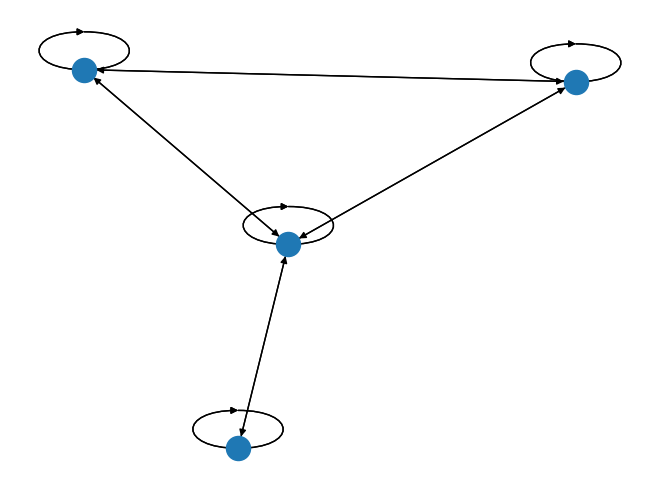

In [5]:
src, dest = torch.nonzero(adj_matrix[0], as_tuple=True)
g = dgl.graph((src,dest))
nx.draw(g.add_self_loop().to_networkx())

In [6]:
node_feats

tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

In [7]:
with torch.no_grad():
    print(GraphConvDGL(g, node_feats[0]).shape)
    GraphConvDGL(g, node_feats[0])

GraphConv(in=2, out=2, normalization=right, activation=None)
torch.Size([4, 2])
GraphConv(in=2, out=2, normalization=right, activation=None)


In [8]:
class GCNLayer(nn.Module):

    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """

        Args:
            node_feats (_type_): batch_size, n, m
            adj_matrix (_type_): n*n
        """
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

In [9]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


In [10]:
out_feats.shape

torch.Size([1, 4, 2])

## Graph attention

### Node level

In [11]:
gatv2conv = GATv2Conv(2, 2, num_heads=1)
gatv2conv(g, node_feats)

tensor([[[-0.7077,  1.1577]],

        [[-0.7091,  1.1550]],

        [[ 1.2537,  5.2344]],

        [[ 1.2537,  5.2344]]], grad_fn=<GSpMMBackward>)

In [12]:
from dgl.data import CoraGraphDataset

dataset = CoraGraphDataset()
g = dataset[0]
num_class = dataset.num_classes
# get node feature
feat = g.ndata['feat']
# get data split
train_mask = g.ndata['train_mask']
val_mask = g.ndata['val_mask']
test_mask = g.ndata['test_mask']
# get labels
label = g.ndata['label']

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.


In [13]:
data_loader = dgl.dataloading.GraphDataLoader(g)

In [14]:
g.ndata['feat'].shape

torch.Size([2708, 1433])

In [15]:
class GATModel(nn.Module):

    def __init__(self, channels_in, channels_hidden, channels_out, num_heads, num_layers=2, dp_rate=0.1):
        super().__init__()
        layers = []
        c_in = channels_in
        for _ in range(num_layers):
            layers.append(GATv2Conv(c_in, channels_hidden, num_heads=num_heads, feat_drop=dp_rate))
            c_in = channels_hidden*num_heads
        layers.append(GATv2Conv(c_in, channels_out, num_heads=num_heads))
        self.layers = nn.ModuleList(layers)
# https://github.com/dmlc/dgl/issues/3448
    def forward(self, g, ft):
        for layer in self.layers:
            print(layer)
            ft = layer(g, ft)
            print(ft.shape)
        return x

In [16]:
gat = GATModel(channels_in=g.ndata['feat'].shape[1],
               channels_out=g.ndata['label'].unique().shape[0],
               channels_hidden=16, num_heads=2)
gat(g, g.ndata['feat'])

GATv2Conv(
  (fc_src): Linear(in_features=1433, out_features=32, bias=True)
  (fc_dst): Linear(in_features=1433, out_features=32, bias=True)
  (feat_drop): Dropout(p=0.1, inplace=False)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)
torch.Size([2708, 2, 16])
GATv2Conv(
  (fc_src): Linear(in_features=32, out_features=32, bias=True)
  (fc_dst): Linear(in_features=32, out_features=32, bias=True)
  (feat_drop): Dropout(p=0.1, inplace=False)
  (attn_drop): Dropout(p=0.0, inplace=False)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (5416x16 and 32x32)

In [ ]:
class NodeClassificationPL(pl.Module):

    def __init__(self):
        self.model = GATModel()

    def forward(self, node_ft, edge):
        note_ft = data[]
        self.model(node_ft, edge)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.cuda.amp import autocast, GradScaler
import dgl
from dgl.nn import GATConv

use_fp16 = True


class GAT(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_classes,
                 heads):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(GATConv(in_feats, n_hidden, heads[0], activation=F.elu))
        self.layers.append(GATConv(n_hidden * heads[0], n_hidden, heads[1], activation=F.elu))
        self.layers.append(GATConv(n_hidden * heads[1], n_classes, heads[2], activation=F.elu))

    def forward(self, g, h):
        for l, layer in enumerate(self.layers):
            h = layer(g, h)
            if l != len(self.layers) - 1:
                h = h.flatten(1)
            else:
                h = h.mean(1)
        return h

# Data loading
data = CoraGraphDataset()
device = "cpu"
g = data[0]
g = dgl.add_self_loop(g)
g = g.int().to(device)
train_mask = g.ndata['train_mask']
features = g.ndata['feat']
labels = g.ndata['label']
in_feats = features.shape[1]
n_hidden = 256
n_classes = data.num_classes
n_edges = g.number_of_edges()
heads = [1, 1, 1]
model = GAT(in_feats, n_hidden, n_classes, heads)
model = model.to(device)

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=5e-4)
# Create gradient scaler
scaler = GradScaler()

for epoch in range(100):
    model.train()
    optimizer.zero_grad()

    # Wrap forward pass with autocast
    with autocast(enabled=use_fp16):
        logits = model(g, features)
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

    if use_fp16:
        # Backprop w/ gradient scaling
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
    else:
        loss.backward()
        optimizer.step()

    print('Epoch {} | Loss {}'.format(epoch, loss.item()))

  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done loading data from cached files.
Epoch 0 | Loss 1.9464285373687744
Epoch 1 | Loss 1.930116891860962
Epoch 2 | Loss 1.9133331775665283


/Users/chaum/code/oc_play/venv/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/Users/chaum/code/oc_play/venv/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Epoch 3 | Loss 1.8966186046600342
Epoch 4 | Loss 1.8795205354690552
Epoch 5 | Loss 1.8617174625396729
Epoch 6 | Loss 1.8431038856506348
Epoch 7 | Loss 1.8235259056091309
Epoch 8 | Loss 1.802789330482483
Epoch 9 | Loss 1.7807276248931885
Epoch 10 | Loss 1.7572115659713745
Epoch 11 | Loss 1.7321330308914185
Epoch 12 | Loss 1.7054029703140259
Epoch 13 | Loss 1.6769614219665527
Epoch 14 | Loss 1.6467628479003906
Epoch 15 | Loss 1.6147487163543701
Epoch 16 | Loss 1.5808830261230469
Epoch 17 | Loss 1.5451945066452026
Epoch 18 | Loss 1.5077282190322876
Epoch 19 | Loss 1.468510389328003
Epoch 20 | Loss 1.4275953769683838
Epoch 21 | Loss 1.385091781616211
Epoch 22 | Loss 1.3411457538604736
Epoch 23 | Loss 1.2958875894546509
Epoch 24 | Loss 1.2494970560073853
Epoch 25 | Loss 1.202166199684143
Epoch 26 | Loss 1.1541026830673218
Epoch 27 | Loss 1.1055423021316528
Epoch 28 | Loss 1.056715726852417
Epoch 29 | Loss 1.0078448057174683
Epoch 30 | Loss 0.9591891765594482
Epoch 31 | Loss 0.91098886728286

In [26]:
print(model.layers)

ModuleList(
  (0): GATConv(
    (fc): Linear(in_features=1433, out_features=256, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (1): GATConv(
    (fc): Linear(in_features=256, out_features=256, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (2): GATConv(
    (fc): Linear(in_features=256, out_features=7, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
)
